# Imports

In [1]:
import math

In [373]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [42]:
device = 'cuda'

# The dataset

In [5]:
iris = datasets.load_iris()
inputs, targets = torch.tensor(iris.data[:]), torch.tensor(iris.target[:])

In [6]:
inputs.shape, targets.shape

(torch.Size([150, 4]), torch.Size([150]))

In [27]:
n_classes = len(targets.unique())

In [7]:
ds = TensorDataset(inputs, targets)

In [8]:
dl = DataLoader(ds, batch_size=32)

In [9]:
x, y = next(iter(dl))
x = x.float()

In [10]:
in_features = inputs.shape[-1]

# Sparsemax

In [478]:
from torch import nn
from torch.autograd import Function
import torch.nn.functional as F

import torch

"""
Other possible implementations:
https://github.com/KrisKorrel/sparsemax-pytorch/blob/master/sparsemax.py
https://github.com/msobroza/SparsemaxPytorch/blob/master/mnist/sparsemax.py
https://github.com/vene/sparse-structured-attention/blob/master/pytorch/torchsparseattn/sparsemax.py
"""


# credits to Yandex https://github.com/Qwicen/node/blob/master/lib/nn_utils.py
def _make_ix_like(input, dim=0):
    d = input.size(dim)
    rho = torch.arange(1, d + 1, device=input.device, dtype=input.dtype)
    view = [1] * input.dim()
    view[0] = -1
    return rho.view(view).transpose(0, dim)


class SparsemaxFunction(Function):
    """
    An implementation of sparsemax (Martins & Astudillo, 2016). See
    :cite:`DBLP:journals/corr/MartinsA16` for detailed description.
    By Ben Peters and Vlad Niculae
    """

    @staticmethod
    def forward(ctx, input, dim=-1):
        """sparsemax: normalizing sparse transform (a la softmax)
        Parameters:
            input (Tensor): any shape
            dim: dimension along which to apply sparsemax
        Returns:
            output (Tensor): same shape as input
        """
        ctx.dim = dim
        max_val, _ = input.max(dim=dim, keepdim=True)
        input -= max_val  # same numerical stability trick as for softmax
        tau, supp_size = SparsemaxFunction._threshold_and_support(input, dim=dim)
        output = torch.clamp(input - tau, min=0)
        ctx.save_for_backward(supp_size, output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        supp_size, output = ctx.saved_tensors
        dim = ctx.dim
        grad_input = grad_output.clone()
        grad_input[output == 0] = 0

        v_hat = grad_input.sum(dim=dim) / supp_size.to(output.dtype).squeeze()
        v_hat = v_hat.unsqueeze(dim)
        grad_input = torch.where(output != 0, grad_input - v_hat, grad_input)
        return grad_input, None

    @staticmethod
    def _threshold_and_support(input, dim=-1):
        """Sparsemax building block: compute the threshold
        Args:
            input: any dimension
            dim: dimension along which to apply the sparsemax
        Returns:
            the threshold value
        """

        input_srt, _ = torch.sort(input, descending=True, dim=dim)
        input_cumsum = input_srt.cumsum(dim) - 1
        rhos = _make_ix_like(input, dim)
        support = rhos * input_srt > input_cumsum

        support_size = support.sum(dim=dim).unsqueeze(dim)
        tau = input_cumsum.gather(dim, support_size - 1)
        tau /= support_size.to(input.dtype)
        return tau, support_size


sparsemax = SparsemaxFunction.apply


class Sparsemax(nn.Module):

    def __init__(self, dim=-1):
        self.dim = dim
        super(Sparsemax, self).__init__()

    def forward(self, input):
        return sparsemax(input, self.dim)

# The  Model

In [479]:
class GLU(nn.Module):

    def __init__(self, units):
        super().__init__()
        self.units = units

    def forward(self, x):

        return x[:, :self.units] * torch.sigmoid(x[:, self.units:])

In [480]:
class FeatureTransformer(nn.Module):

    def __init__(self, in_features, out_features, bn_momentum, previous_transformer=None):
        super().__init__()
        self.block1 = self.block(in_features, out_features, bn_momentum)
        self.block2 = self.block(out_features, out_features, bn_momentum)
        self.previous_transformer = previous_transformer

    def block(self, in_features, out_features, bn_momentum):
        return nn.Sequential(
            nn.Linear(in_features, out_features * 2, bias=False),
            nn.BatchNorm1d(out_features * 2, momentum=bn_momentum),
            GLU(out_features)
        )

    def forward(self, x):
        if self.previous_transformer is not None:
            x = self.previous_transformer(x)

        o1 = self.block1(x)

        if self.previous_transformer is not None:
            o1 = (o1 + x) * math.sqrt(0.5)

        o2 = self.block2(o1)
        return (o2 + o1) * math.sqrt(0.5)

In [481]:
class AttentiveTransformer(nn.Module):

    def __init__(self, comp_size, n_features, relaxation_factor, epsilon):
        super().__init__()
        self.relaxation_factor = relaxation_factor
        self.epsilon = epsilon

        self.dense = nn.Linear(comp_size, n_features)
        self.bn = nn.BatchNorm1d(n_features)
        self.sparsemax = Sparsemax()

    def forward(self, features_for_coef, complemantary_aggregated_mask_values):
        mask_values = self.dense(features_for_coef)
        mask_values = self.bn(mask_values)
        mask_values =  mask_values * complemantary_aggregated_mask_values
        mask_values = self.sparsemax(mask_values)

        complemantary_aggregated_mask_values = complemantary_aggregated_mask_values * (
            self.relaxation_factor - mask_values)
        entropy = torch.sum(-mask_values *
                            torch.log(mask_values + self.epsilon), dim=1)
        entropy = entropy.mean()
        return mask_values, complemantary_aggregated_mask_values, entropy

In [482]:
class TabNet(nn.Module):

    def __init__(self, n_features, hidden_size, output_dim, decision_steps=2,
                 relaxation_factor=1, epsilon=1e-4, bn_momentum=0.7):
        super().__init__()

        self.hidden_size = hidden_size
        self.output_dim = output_dim
        self.n_features = n_features
        self.decision_steps = decision_steps
        self.bn_momentum = bn_momentum

        self.bn = nn.BatchNorm1d(n_features, momentum=self.bn_momentum)

        # feature transformer shared accross steps
        self.shared_transformer = FeatureTransformer(n_features, hidden_size)

        # step dependent feature transformer
        self.step_transformers = nn.ModuleList([
            FeatureTransformer(hidden_size, hidden_size, self.bn_momentum,
                               self.shared_transformer)
            for _ in range(decision_steps)
        ])

        self.attentive_transformers = nn.ModuleList([
            AttentiveTransformer(
                self.hidden_size-self.output_dim, self.n_features, relaxation_factor, epsilon)
            for _ in range(decision_steps - 1)
        ])

    def forward(self, x, output_masks=False):
        x = self.bn(x)  # applies batch norm on the input
        batch_size = x.shape[0]
        output_aggregated = torch.zeros(batch_size, self.output_dim).to(device)
        mask_values = torch.zeros(batch_size, self.n_features).to(device)
        aggregated_mask_values = torch.zeros(
            batch_size, self.n_features).to(device)
        complemantary_aggregated_mask_values = torch.ones(
            batch_size, self.n_features).to(device)
        total_entropy = 0

        mask_values_per_step = []

        masked_features = x

        for i, step_transformer in enumerate(self.step_transformers):

            o = step_transformer(masked_features)

            if i > 0:
                decision_out = F.relu(o[:, :self.output_dim])
                output_aggregated = output_aggregated + decision_out

                # for visualization
                scale_agg = torch.sum(
                    decision_out, dim=1, keepdim=True) / (self.decision_steps - 1)
                aggregated_mask_values = aggregated_mask_values + mask_values * scale_agg

            features_for_coef = o[:, self.output_dim:]

            if i < self.decision_steps - 1:
                attentive_transformer = self.attentive_transformers[i]
                mask_values, complemantary_aggregated_mask_values, entropy = attentive_transformer(
                    features_for_coef, complemantary_aggregated_mask_values)
                total_entropy = total_entropy + \
                    entropy / (self.decision_steps - 1)

                masked_features = mask_values * x

                if output_masks:
                    mask_values_per_step.append(mask_values.detach().cpu())

        outputs = (output_aggregated, total_entropy)
        if output_masks:
            outputs = outputs + (aggregated_mask_values, mask_values_per_step)

        return outputs

In [483]:
class TabNetClassifier(nn.Module):
    
    def __init__(self, tabnet, output_dim, n_classes):
        super().__init__()
        self.tabnet = tabnet
        self.classifier = nn.Linear(output_dim, n_classes)
    
    def forward(self, x):
        output_aggregated, total_entropy = self.tabnet(x)
        return self.classifier(output_aggregated)
    
    def to(self, device):
        self.tabnet.to(device)
        self.classifier.to(device)

In [484]:
out_features = 16
output_dim = 8

In [564]:
tabnet = TabNet(in_features, out_features, output_dim, decision_steps=4)
model = TabNetClassifier(tabnet, output_dim, n_classes)

In [565]:
device = 'cuda'

In [566]:
model.to(device)

In [567]:
with torch.no_grad():
    out = model(x.float().to(device))

# Training

In [568]:
ridx = np.random.permutation(len(inputs))
train_size = round(0.8 * len(inputs))
train_idx = ridx[:train_size]
valid_idx = ridx[train_size:]

ds_train = TensorDataset(inputs[train_idx], targets[train_idx])
ds_valid = TensorDataset(inputs[valid_idx], targets[valid_idx])

In [569]:
dl_train = DataLoader(ds_train, batch_size=train_size, num_workers=4)
dl_valid = DataLoader(ds_valid, batch_size=len(ds_valid), num_workers=4)

In [570]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),  lr=1e-3)

In [576]:
for _ in range(60):
    model.train()
    model.tabnet.train()
    
    for x, y in dl_train:
        model.zero_grad()
        
        out = model(x.float().to(device))
        loss = loss_fn(out, y.long().to(device))
        
        loss.backward()
        optimizer.step()
        
    model.eval()
    model.tabnet.eval()
    x, y = next(iter(dl_valid))
    with torch.no_grad():
        out = model(x.float().to(device))
        loss_valid = loss_fn(out, y.long().to(device))
    print(loss_valid)

tensor(0.4800, device='cuda:0')
tensor(0.4795, device='cuda:0')
tensor(0.4805, device='cuda:0')
tensor(0.4807, device='cuda:0')
tensor(0.4799, device='cuda:0')
tensor(0.4801, device='cuda:0')
tensor(0.4802, device='cuda:0')
tensor(0.4789, device='cuda:0')
tensor(0.4763, device='cuda:0')
tensor(0.4725, device='cuda:0')
tensor(0.4691, device='cuda:0')
tensor(0.4667, device='cuda:0')
tensor(0.4629, device='cuda:0')
tensor(0.4596, device='cuda:0')
tensor(0.4598, device='cuda:0')
tensor(0.4574, device='cuda:0')
tensor(0.4491, device='cuda:0')
tensor(0.4412, device='cuda:0')
tensor(0.4420, device='cuda:0')
tensor(0.4467, device='cuda:0')
tensor(0.4306, device='cuda:0')
tensor(0.4120, device='cuda:0')
tensor(0.3958, device='cuda:0')
tensor(0.3861, device='cuda:0')
tensor(0.3804, device='cuda:0')
tensor(0.3757, device='cuda:0')
tensor(0.3718, device='cuda:0')
tensor(0.3737, device='cuda:0')
tensor(0.3756, device='cuda:0')
tensor(0.3675, device='cuda:0')
tensor(0.3708, device='cuda:0')
tensor(0

KeyboardInterrupt: 

In [577]:
(out.argmax(-1).cpu() == y.long()).float().mean()

tensor(1.)

In [578]:
out_agg, _, agg_mask, mask_per_step = model.tabnet(x.float().to(device), True)

In [579]:
out_agg.max(), out_agg.min()

(tensor(8.7213, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0., device='cuda:0', grad_fn=<MinBackward1>))

In [580]:
agg_mask.shape, agg_mask.max(), agg_mask.min()

(torch.Size([120, 4]),
 tensor(4.0263, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0., device='cuda:0', grad_fn=<MinBackward1>))

In [581]:
mask_per_step[2].shape

torch.Size([120, 4])

In [582]:
agg_mask = agg_mask.detach().cpu().numpy()

In [583]:
agg_mask_norm = (agg_mask - agg_mask.min(0)) / (agg_mask.max(0) - agg_mask.min(0))

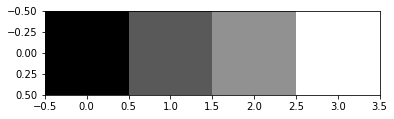

In [592]:
plt.imshow(mask_per_step[1][1].unsqueeze(0), cmap='gray')

In [595]:
sum(mask_per_step)

tensor([[0.3701, 0.3967, 2.2332, 0.0000],
        [0.2653, 1.1035, 0.2962, 1.3350],
        [1.2577, 0.9080, 0.0000, 0.8343],
        [0.9581, 1.0243, 0.0000, 1.0175],
        [0.0000, 0.8861, 1.0622, 1.0517],
        [0.9209, 0.8975, 0.0000, 1.1817],
        [0.0000, 0.5641, 1.1853, 1.2506],
        [0.4527, 1.1838, 0.4944, 0.8691],
        [1.0341, 0.9659, 0.0000, 1.0000],
        [0.9362, 1.0638, 0.0000, 1.0000],
        [0.3808, 0.8690, 0.9031, 0.8471],
        [1.2842, 0.0000, 1.7087, 0.0071],
        [0.3056, 0.7416, 0.4853, 1.4675],
        [0.8606, 0.9423, 0.0000, 1.1971],
        [0.9094, 0.9157, 0.0000, 1.1749],
        [0.7653, 1.2177, 0.1185, 0.8985],
        [0.3162, 0.0388, 1.2908, 1.3541],
        [0.5687, 0.3320, 2.0993, 0.0000],
        [0.3181, 0.0000, 1.9764, 0.7054],
        [0.1541, 0.0000, 1.5158, 1.3301],
        [0.7217, 1.1430, 0.0000, 1.1353],
        [0.8598, 1.0226, 0.0000, 1.1176],
        [0.2964, 0.0147, 1.9223, 0.7666],
        [0.7447, 0.9163, 0.3153, 1

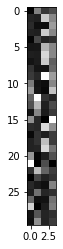

In [502]:
plt.imshow(agg_mask_norm, cmap='gray')